# Modelos Generativos

Las redes neuronales hoy en día han sido aplicados a muchos problemas, de los cuales algunos son necesarios tener un modelo generativo el cual pueda artificialmente sintetizar nuevos ejemplos que sean similares a los originales, éste tipo de aprendizaje se llama **Unsupervised Learning**. Existen diferentes *approaches* para ésto, de los cuales solo veremos 2.

Vamos a trabajar con los datos anteriormente trabajos de MNIST.

In [137]:
from keras.datasets import mnist
import keras
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D, Reshape,Conv2DTranspose,Activation, Lambda
from keras.layers import LeakyReLU, Dropout, BatchNormalization,UpSampling2D
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras import backend as K

from IPython.display import Image, display, SVG

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

import numpy as np

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2],1))
img_rows, img_cols, channel = X_train.shape[1:]
print(img_rows, img_cols, channel)

28 28 1


### 1.1 *Variational Autoencoder* (VAE) [[1]](#refs)

Los VAE son una variación a la arquitectura que ya vimos (autoencoder) en donde la codificación y decodificación están conectadas a través de un enfoque bayesiano en donde la codificación aprende los parámetros de alguna distribución de variables latentes de los datos y en donde el decodificador muestrea de ésta distribución de variables latentes para poder generar nuevos datos artificiales $\hat{x}$. Dicho de otra palabras es un autoencoder que aprende el modelo de las variables latentes de los datos.


El enfoque optimizador de los parámetros de la red neuronal $\theta$ es que minimiza la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) agregando una regularización que se impone para que la distribución aprendida de las variables latentes sea de alguna distribución deseada *a priori*.  

$$ Min \ L(q_{\theta}(x\mid z),x) + KL( q_{\theta}(z\mid x) \mid \mid p_{\theta}(z))$$

Con $L$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[5]](#refs), $q_{\hat{\theta}}(x\mid z)$ la recontrucción aleatoria de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori*. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />


> a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 bloque convolucionales y una bloque *fully conected*, con una distribución Normal multivariada de 2 componentes para las variables latentes. Describa la arquitectura utilizada para el *encoder*.

Como se mencionó más arriba, variational autoencoder tiene un codificador, que toma como *input* los datos de entrada original (*x*), y entrega como *output* una representación oculta de *x*, que llamaremos *z*, el cual tiene pesos entre las neuronas como parámetros del encoder.

A continuación se fijan los siguientes parámetros:  **PREGUNTAR**

In [4]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

In [5]:
print("Dimensiones de la imagen a procesar: ", original_img_size)
print("Cantidad de filtros convolucionales: ", filters)
print("Tamaño del kernel convolucional: ", num_conv)
print("Dimensiones de la capa intermedia entre x y z: ", intermediate_dim)
print("Dimensiones latentes de z: ", latent_dim)

Dimensiones de la imagen a procesar:  (28, 28, 1)
Cantidad de filtros convolucionales:  32
Tamaño del kernel convolucional:  3
Dimensiones de la capa intermedia entre x y z:  128
Dimensiones latentes de z:  2


Una vez definidos los hiper-parámetro, se procede a definir y explicar la arquitectura del encoder.

In [6]:
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [7]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

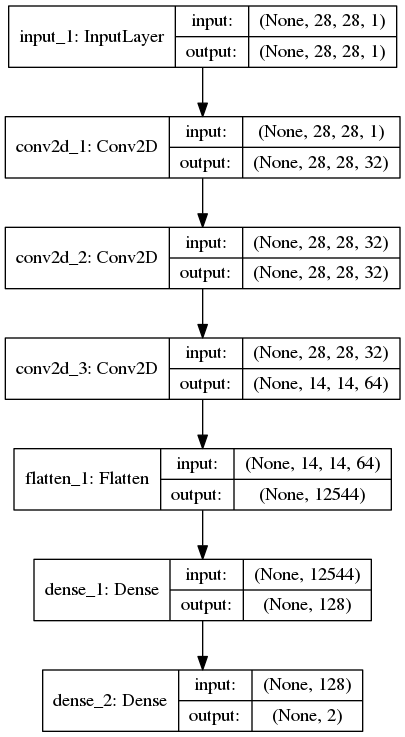

In [7]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

<a id="a"></a>
La arquitectura del autoencoder consta de una capa de entrada que recibe imágenes de dimensiones 28x28x1. Luego tiene 3 capas <a id="conv">convolucionales</a>, donde la primera y segunda tiene 32 filtros, y la tercera tiene el doble, 64. Todas estas capas tienen el kernel convolucional de 3x3 y función de activación ReLU. Las primeras dos capas mantienen dimensiones de entrada de imagen de 28x28 y la tercera tiene como input 28x28 y output 14x14, debido al parámetro *stride=2*.

Luego, viene una capa <a id="flatten">*flatten*</a> que "aplana" la entrada, es decir de 3 dimensiones pasa a 1, en este caso pasa de una capa de 14x14x64 a una de 12.544, que justamente corresponde a la multiplicación de las 3 dimensiones de entrada. 

Finalmente, hay dos capas densas, que se encargan de reducir la dimensionalidad de los <a id="1_dense_enc">12.544</a>, obtenidos en el *flatten* a 2 dimensiones correspondientes a las dos componentes de las variables latentes. Pasando por <a id="2_dense_enc">128</a> neuronas entre las dos capas densas.

> b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y con 3 bloque de la operación inversa a una convolución (**Convolución transpuesta** [[2]](#refs)), comente cómo ésta trabaja y los parámetros de stride como funcionan. Además se *setea* la distribución de las variables latentes como una distribución Normal multivariada de 2 componentes.

Por otro lado, variational autoencoder tiene un decodificador, otra red neuronal, que se encarga de tomar como input la representación *z* obtenida en el encoder, y como output entrega muestras de la distribución de variables latentes. Desde otro punto de vista, el dencoder se puede ver como la  probabilidad de encontrar muestras de X dada las componentes latentes encontradas en el encoder, $P(\hat x | z)$. Por lo tanto, el decoder intenta recontruir los datos originales.

A continuación se define la arquitectura que tendrá el decoder, que dicho de una forma simplista, es básicamente es el encoder, pero al revés.

In [8]:
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu') #128
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu') #14x14x64=12544
decoder_reshape = Reshape(shape_before_flattening)#14x14x64
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

<a id="b"></a>
La arquitectura del decoder primero cuenta con dos capas densas:
* *decoder_hid* = Recostruye la capa de 128 neuronas con función de activación ReLU. Esta capa hace [referencia](#2_dense_enc) a la última capa densa del encoder.   
* *decoder_upsample* = Reconstituye la capa de 12.544 neuronas, hace [referencia](#1_dense_enc) a la primera capa densa del encoder. 

Luego viene una capa que lleva los datos a una dimensión de 14x14x64, que expande las neuronas para luego poder ser usadas por las capas convolucionales. Así esta capa sería el ingreso a la capa [*flatten*](#flatten) del encoder.

Y, finalmente, vienen 3 capas convolucionales transpuestas. Una capa convolucional transpuesta o también llamada deconvolucional, es una operación que va en dirección opuesta a la de una convolución normal, es decir, realiza una transformación que lleva desde algún resultado convolucional, con una forma de salida correspondiente, a su entrada convolucional, también con su forma correspondiente. Hay que tener cuidado con que el patrón de conectividad se mantenga. Dentro de esta capa hay un parámetro llamado *stride*, al igual que en una capa convolucional normal, pero ahora juega el rol contrario. Es decir, en la convolución normal se encarga de contraer la imagen según la cantidad de *stride* indicada, ahora en la deconvolución se encarga de expandir la capa en la cantidad de *stride* indicada.
Claramente las capas deconvolucionales hacen [referencia](#conv) a las capas convolucionales del encoder.


In [9]:
decoder_upsample.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_5',
 'trainable': True,
 'units': 12544,
 'use_bias': True}

In [10]:
decoder_reshape.get_config()

{'name': 'reshape_1', 'target_shape': (14, 14, 64), 'trainable': True}

In [11]:
decoder_hid.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_4',
 'trainable': True,
 'units': 128,
 'use_bias': True}

> c) Defina la sección que conecta a estas dos partes a través de un *sampleo* implicito ($g = \mu_{z^{(i)}} + \sigma_{z^{(i)}}\cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilistico/bayesiano. Describa el modelo completo.

A continuación se setea la distribución de las variables latentes como una distribución normal multivariada de 2 componentes, las cuales fueron definidas en las últimas capas del encoder, *z_mean y z_log_var*.


In [12]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon


Luego, se define la sección que produce el enfoque bayesiano de este método, que conecta las dos partes definidas anteriormente mediante una muestra implicita, obtenida de la función anterior.

In [13]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [22]:
print(z)

Tensor("lambda_1/add:0", shape=(?, 2), dtype=float32)


Así, la estructura final del modelo sería:

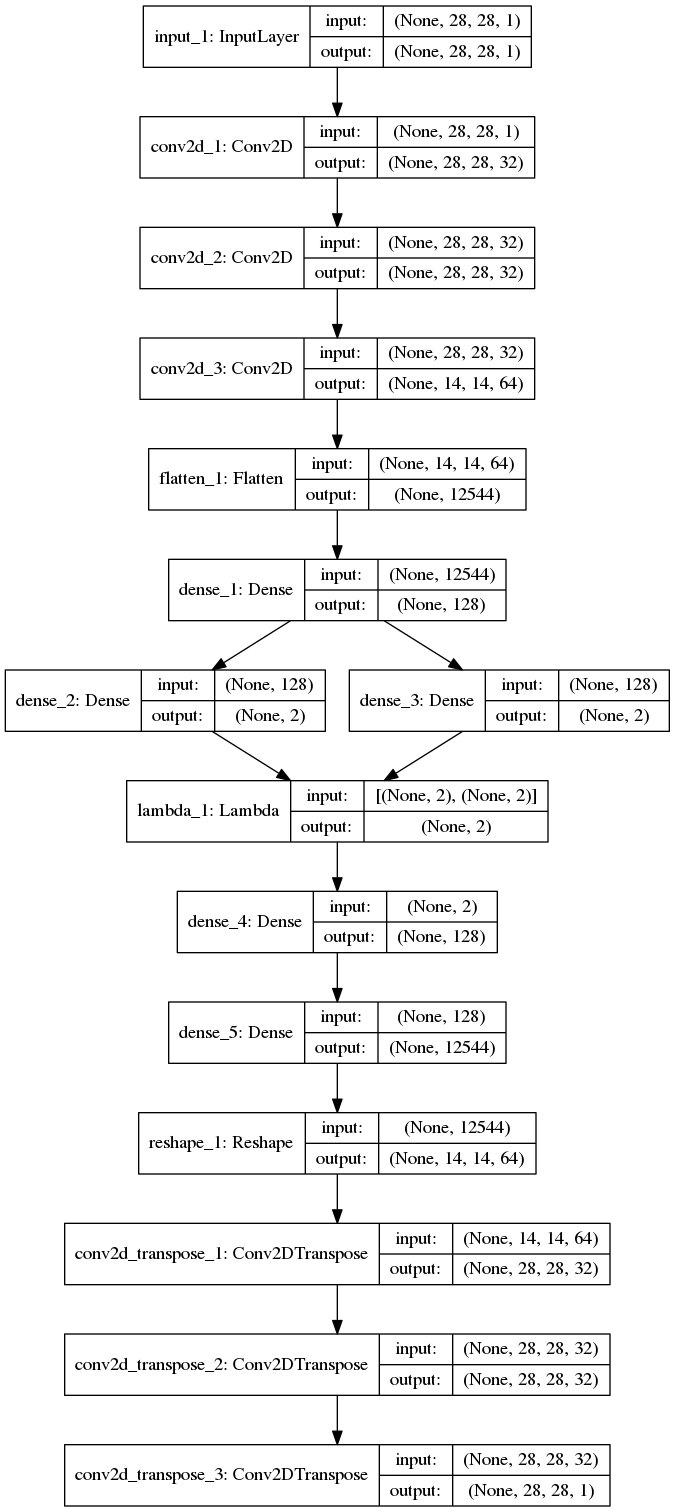

In [14]:
plot_model(vae, to_file='vae.png', show_shapes=True)
Image(filename='vae.png')

Según el diagrama se ve como se une el encoder y decoder. Hay que tener en cuenta que en la unión de estas redes, se produce una bifurcación de dos capas densas, la cual se produce por cada una de las componentes latentes no dimensionales de la distribución normal multivariada, la media y matriz de covarianza. Y luego, la siguiente capa de tipo *Lambda* se encarga de samplear muestras de la distribución definida. 

Así, el modelo final de autoencoder se compone de la red encoder explicada en [a](#a), la intersección explicada en el párrafo anterior y finalmente viene la red decoder explicada en [b](#b).


> d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

Lo que falta por definir es la función objetivo que tendrá la red autoencoder. Esta función objtivo se define a continuación como la fución de pérdida para la reconstrucción más un regularizador.

La función de pérdida de reconstrucción será la binary cross entropy, debido a que se aplicará por pixel, e intenta forzar a las muestras decodificadas a ser parecidas o iguales a las entradas iniciales. Y el regularizador de la función de pérdida a utilizar será Kullback-Leibler Divergence (KL Divergence). KL Divergence es una medida que entrega la similitud entre dos distribuciones de probabilidad, es decir, al momento de comparar dos distribuciones $ ( KL(p,q))$, *p* y *q*, KL divergence nos dirá que tanto se parecen *p* y *q*, pero hay que tener en cuenta que la $KL(p,q)\neq KL(q,p)$.
## REVISAR LO ANT
En este caso la KL es entre la distribución latente aprendida y una distribución a prior sobre las variables latentes. Ésta última corresponde una la suposición que hacemos sobre los datos, que en este caso será una normal con media $0$ y de matriz de covarianza la matriz identidad. Este término en la función de pérdida trabaja como regularizador, ya que a medida que es más alta, o sea que las distribuciones se alejan entre sí, la pérdida será mayor, pero a medida que las distribuciones se parecen la pérdida no aumentará más de lo que indique la pérdida de reconstrucción. En el fondo funciona como penalizador entre la distribución de las variables latentes y la distribución definida a priori.

In [15]:
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash)) 
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel * choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

Así, queda el modelo final de autoencoder:

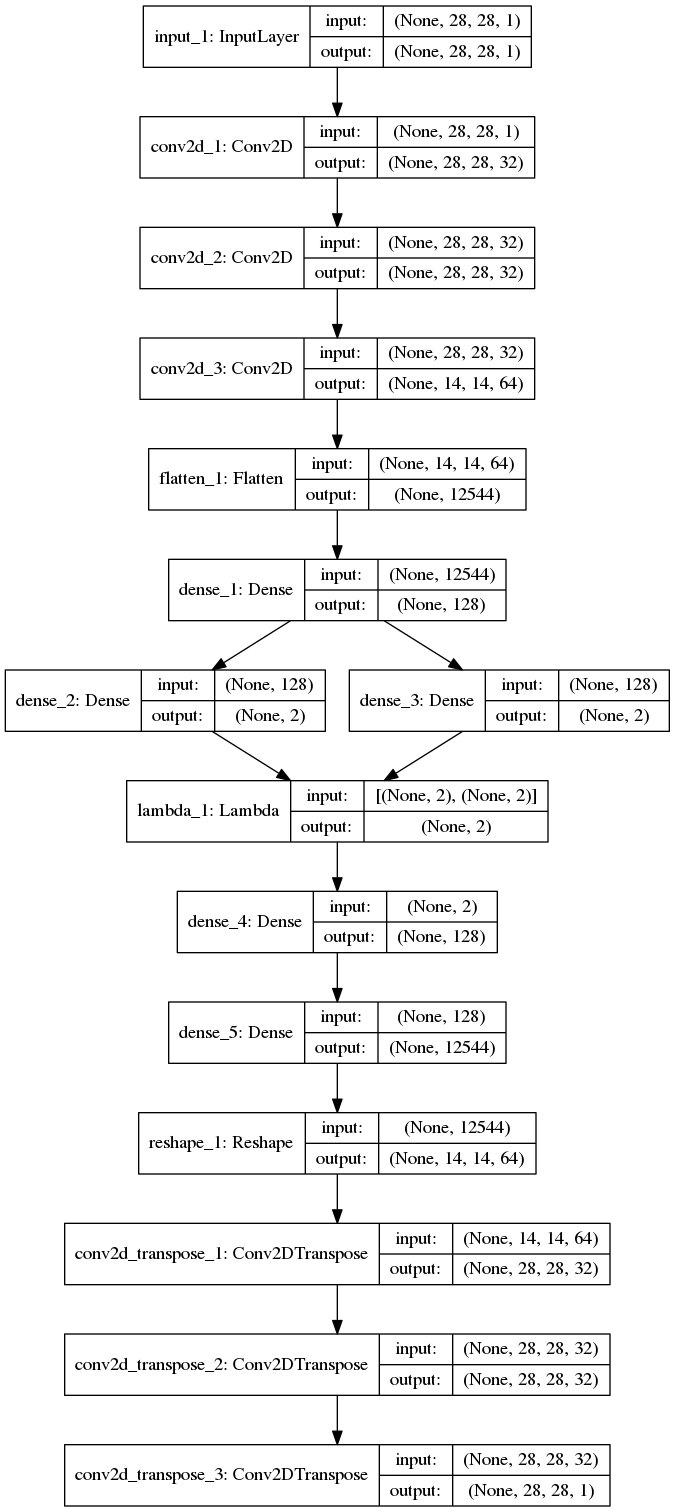

In [16]:
plot_model(vae, to_file='vae_2.png', show_shapes=True)
Image(filename='vae_2.png')

> e) Entrene el modelo definido con los datos de MNIST entre 10 a 15 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

Una vez que se tiene el modelo variational autoencoder definido, se procede a entrenarlo, para esto se definen los parámetros necesarios:

* *batch_size*: 128. En una primera instancias se prueba con este valor por un tema de limitaciones de memoria, y además porque en varios experimentos encontrados en internet se utiliza este valor con buenos resultados.
* *epochs*: 15
* *optimizer*: RMSprop

In [17]:
print(X_test.shape)
print(X_train.shape)

(10000, 28, 28, 1)
(60000, 28, 28, 1)


In [18]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [ ]:
batch_size = 128
epochs = 15
vae.compile(optimizer='rmsprop', metrics=['acc'])
hist_vae = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 419s 7ms/step - loss: 142.0115 - val_loss: 143.9324
Epoch 2/15
60000/60000 [==============================] - 422s 7ms/step - loss: 141.4058 - val_loss: 142.8615
Epoch 3/15
60000/60000 [==============================] - 422s 7ms/step - loss: 140.9031 - val_loss: 143.9537
Epoch 4/15
60000/60000 [==============================] - 429s 7ms/step - loss: 140.5621 - val_loss: 142.2449
Epoch 5/15
60000/60000 [==============================] - 428s 7ms/step - loss: 140.3123 - val_loss: 143.2266
Epoch 6/15
60000/60000 [==============================] - 432s 7ms/step - loss: 140.0377 - val_loss: 142.6515
Epoch 7/15
60000/60000 [==============================] - 435s 7ms/step - loss: 139.7614 - val_loss: 143.7259
Epoch 8/15
60000/60000 [==============================] - 433s 7ms/step - loss: 139.7229 - val_loss: 141.6596
Epoch 9/15
60000/60000 [==============================] - 433s 7ms/ste

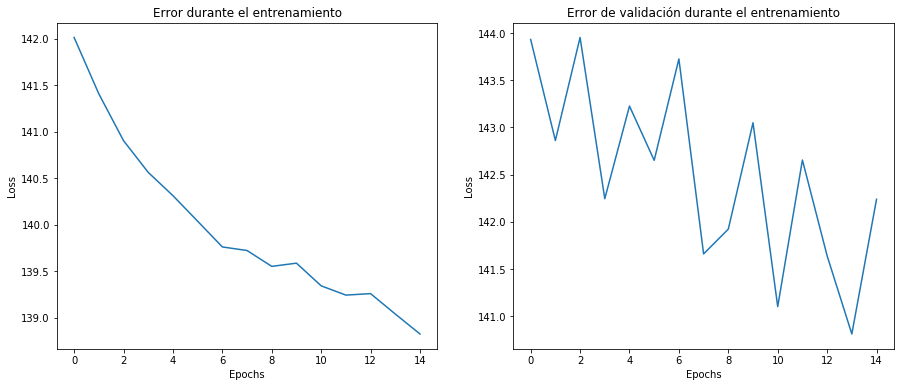

In [111]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(range(epochs), hist_vae.history['loss'])
plt.title("Error durante el entrenamiento")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(range(epochs), hist_vae.history['val_loss'])
plt.title("Error de validación durante el entrenamiento")
plt.ylabel('Loss')
plt.xlabel('Epochs')
    
plt.show()

De los gráficos anteriores se puede ver que la pérdida durante el entrenamiento para el conjunto de datos de entrenamiento va disminuyendo gradualmente durante los 15 epochs de entrenamiento, pero en el conjunto de datos de validación la pérdida es muy fluctuante entre epochs, aunque a pesar de esto se ve que va disminuyendo, pero lentamente. Hay que notar que la pérdida obtenida en ambos conjuntos de datos es alta.

> f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_{z^{(i)}}$. Además genere un histograma de la media y la varianza $\sigma_{z^{(i)}}^2$ de las dos componentes. Comente



Una vez entrenado el vae se pueden observar las variables latentes encontradas, y así, éstos resultados se pueden comparar con el prior utilizado, corroborando o refutado lo que se creía en un principio.

Para lo anterior, y dado que el espacio latene es bidimensional, se muestra un *scatter_plot* de los valores encontrados por la red.

In [45]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
#print(x_test_encoded)

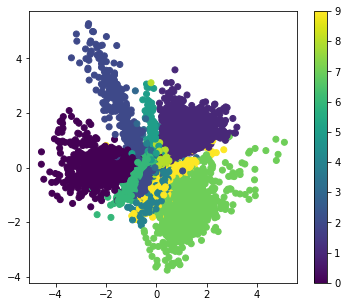

In [46]:
plt.figure(figsize=(6, 5))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

El gráfico anterior muestra el vencidario de las diferentes clases de los datos, así, cada uno de los clusters representa un dígito diferente. Los cluster cercanos indican digitos que son parecidos, o sea que se escriben similar y tienen estructuras semejantes, por lo que a su vez comparten información en el espacio latente.

Se puede ver que el promedio de las 

In [49]:
np.mean(x_test_encoded,axis=0)

array([-0.01142383, -0.00547785], dtype=float32)

In [107]:
x_test_encoded[:,0]

array([ 1.7021163 , -0.24976629,  1.4809911 , ...,  0.33524284,
       -0.03637567, -0.42795515], dtype=float32)

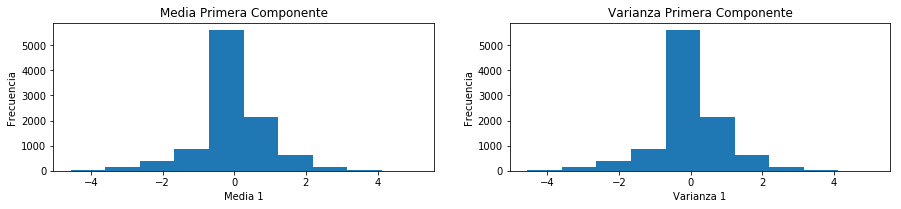

In [109]:
encoder_log_var = Model(x,z_log_var)
#histogram
plt.figure(1, figsize=(15,6))

plt.subplot(221)
plt.hist(x_test_encoded[:,0])
plt.xlabel("Media 1")
plt.ylabel("Frecuencia")
plt.title("Media Primera Componente")

plt.subplot(222)
plt.hist(x_test_encoded[:,0])
plt.xlabel("Varianza 1")
plt.ylabel("Frecuencia")
plt.title("Varianza Primera Componente")

# plt.subplot(223)
# plt.hist(np.asarray(z_mean[1])[:])
# plt.set_xlabel("Media 2")
# plt.set_ylabel("Frecuencia")
# plt.set_title("Media Segunda Componente")

# plt.subplot(224)
# plt.hist(np.asarray(z_log_var[1])[:], facecolor='green', alpha=0.5)
# plt.set_xlabel("Varianza")
# plt.set_ylabel("Frecuencia", fontsize=14)
# plt.set_title("Varianza Segunda Componente")

plt.show()

([array([3.600e+01, 1.780e+02, 4.160e+02, 8.980e+02, 5.989e+03, 1.808e+03,
         5.630e+02, 9.200e+01, 1.500e+01, 5.000e+00]),
  array([4.000e+00, 4.400e+01, 2.850e+02, 1.361e+03, 6.299e+03, 1.330e+03,
         5.150e+02, 1.130e+02, 3.400e+01, 1.500e+01])],
 array([-4.56476545, -3.58113346, -2.59750147, -1.61386948, -0.63023748,
         0.35339451,  1.3370265 ,  2.32065849,  3.30429049,  4.28792248,
         5.27155447]),
 <a list of 2 Lists of Patches objects>)

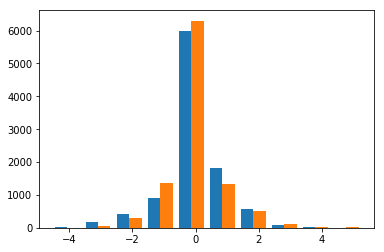

In [87]:
plt.hist(x_test_encoded)

In [88]:
x_train_encoded = encoder.predict(X_train, batch_size=batch_size)

([array([4.6000e+01, 6.1100e+02, 2.3410e+03, 5.0870e+03, 3.1409e+04,
         1.6099e+04, 3.7860e+03, 5.2500e+02, 7.5000e+01, 2.1000e+01]),
  array([    0.,    98.,  1216.,  5035., 35749., 12960.,  3690.,   877.,
           312.,    63.])],
 array([-5.11305714, -4.05150905, -2.98996096, -1.92841287, -0.86686478,
         0.19468331,  1.2562314 ,  2.31777949,  3.37932758,  4.44087567,
         5.50242376]),
 <a list of 2 Lists of Patches objects>)

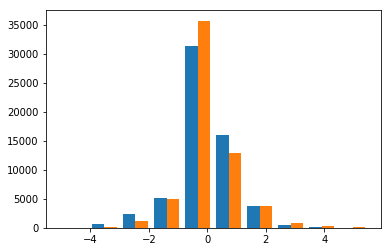

In [89]:
plt.hist(x_train_encoded)

> g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?



In [73]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

In [99]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]

In [95]:
def plot_generate(figure, image_size, grid_x, grid_y):
    plt.figure(figsize=(10, 10))
    plt.imshow(figure,cmap='gnuplot2')
    pos = np.arange(image_size/2,image_size*n,image_size)
    plt.yticks(pos,np.round(grid_y,1))
    plt.xticks(pos,np.round(grid_x,1))
    plt.show()

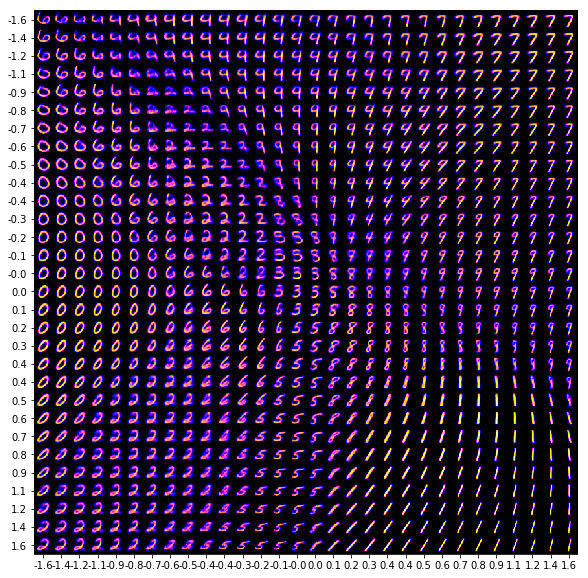

In [100]:
plot_generate(figure, image_size, grid_x, grid_y)

In [103]:
n = 30  # figure with 15x15 images 
image_size_2 = img_cols
figure_2 = np.zeros((image_size * n, image_size * n))
#en los extremos del intervalo de confianza
grid_x_2 = norm.ppf(np.linspace(0.000005, 0.999995, n)) 
grid_y_2 = norm.ppf(np.linspace(0.000005, 0.999995, n)) 
for i, yi in enumerate(grid_x_2):
    for j, xi in enumerate(grid_y_2):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure_2[i * image_size_2: (i + 1) * image_size_2,
               j * image_size_2: (j + 1) * image_size_2] = x_decoded[0][:,:,0]

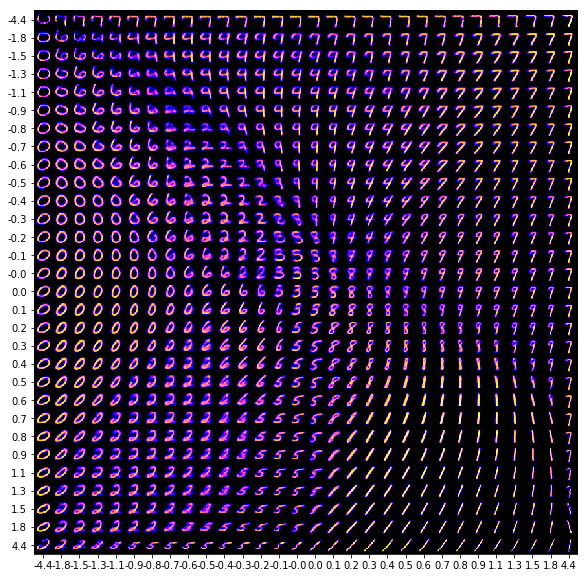

In [104]:
plot_generate(figure_2, image_size_2, grid_x_2, grid_y_2)

> h) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida diferente a la Normal y muestre sobre el cómo debiera ser implementada.

In [112]:
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu') #128
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu') #14x14x64=12544
decoder_reshape = Reshape(shape_before_flattening)#14x14x64
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

2. Analogous to the Gaussian example, for any ”location-scale” family of distributions we can
choose the standard distribution (with location = 0, scale = 1) as the auxiliary variable
, and let g(.) = location + scale · . Examples: Laplace, Elliptical, Student’s t, Logistic,
Uniform, Triangular and Gaussian distributions.

https://arxiv.org/pdf/1312.6114.pdf

In [115]:
#https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_uniform
def sampling_unif(args):
    z_mean, z_log_var = args
    epsilon = K.random_uniform(shape=(K.shape(z_mean)[0], latent_dim),minval=-1., maxval=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [116]:
z = Lambda(sampling_unif, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae_unif = Model(x, x_decoded_mean_squash)

# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash)) 
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel * choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_unif.add_loss(vae_loss)

In [117]:
batch_size = 128
epochs = 15
vae_unif.compile(optimizer='rmsprop', metrics=['acc'])
hist_vae_unif = vae_unif.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 480s 8ms/step - loss: 182.1395 - val_loss: 161.1639
Epoch 2/15
60000/60000 [==============================] - 431s 7ms/step - loss: 157.6298 - val_loss: 154.8344
Epoch 3/15
60000/60000 [==============================] - 430s 7ms/step - loss: 152.4767 - val_loss: 149.4309
Epoch 4/15
60000/60000 [==============================] - 425s 7ms/step - loss: 149.5224 - val_loss: 147.8519
Epoch 5/15
60000/60000 [==============================] - 423s 7ms/step - loss: 147.4689 - val_loss: 146.3564
Epoch 6/15
60000/60000 [==============================] - 419s 7ms/step - loss: 145.9309 - val_loss: 146.2404
Epoch 7/15
60000/60000 [==============================] - 434s 7ms/step - loss: 144.6694 - val_loss: 147.0166
Epoch 8/15
60000/60000 [==============================] - 436s 7ms/step - loss: 143.7046 - val_loss: 144.6091
Epoch 9/15
60000/60000 [==============================] - 439s 7ms/ste

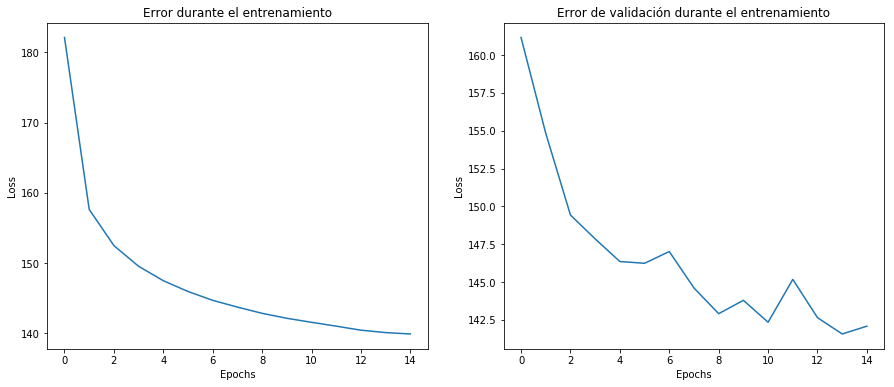

In [118]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(range(epochs), hist_vae_unif.history['loss'])
plt.title("Error durante el entrenamiento")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(range(epochs), hist_vae_unif.history['val_loss'])
plt.title("Error de validación durante el entrenamiento")
plt.ylabel('Loss')
plt.xlabel('Epochs')
    
plt.show()

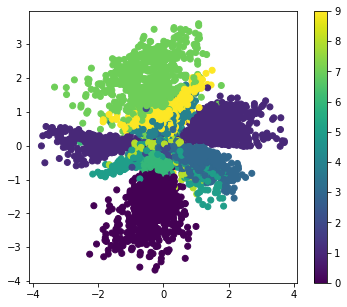

In [119]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 5))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [120]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

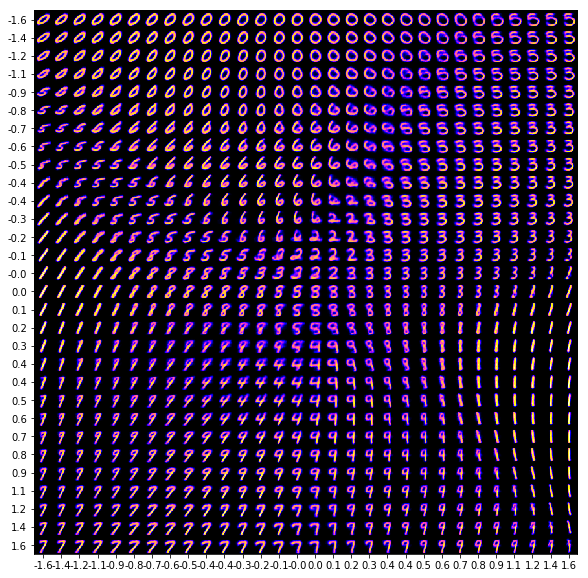

In [121]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
        
plot_generate(figure, image_size, grid_x, grid_y)

## 1.2 Generative Adversarial Networks (GAN) 

Las GAN son un enfoque distinto de modelo generativo. A pesar de que tiene dos redes conectadas, las tareas que realiza cada una de ella son distintas. Se trata de un modelo adversario en que una red *compite* con la otra. Por un lado se tiene la red discriminadora $D$ que intenta disernir si un dato proviene de los datos reales o fue un dato generado artificialmente. Por otro lado se tiene la red generadora $G$ que intenta generar datos artificialmente de manera que la red discriminadora se confunda, es decir, sea lo más similar a los datos reales. 

<img src="https://oshearesearch.com/wp-content/uploads/2016/07/mnist_gan.png" title="VAE" width="60%" />


El enfoque optimizador de los parámetros de la red neuronal es para $D$ el de maximizar la probabilidad de los datos que provienen de la distribución original minimizando la probabilidad de los datos que provienen del modelo generativo. Mientras que para $G$ es el de maximizzar la probabilidad de que $D$ asigne un dato de $G$ como real, o bien, minimizar la probabilidad de que $D$ asigne un dato de $G$ como corrupto.

$$
min_G \ max_G = E_{x\sim p_{data}(x) }[logD(x)] + E_{z\sim p_z(z)}[log(1-D(G(z))]
$$

Ésto tiene un óptimo teórico que es cuando $p_g = p_{data}$, es decir, cuando el *generador* $G$ logra imitar la distribución de probabilidad de los datos.



> a) Defina al *discriminador* de la GAN como el que se muestra en el código, de 3 bloque convolucionales y una tanda *fully conected*, con los Dropout para evitar *overfitting*. Describa la arquitectura utilizada y cuál es la función de activación seleccionada.

In [218]:
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)

D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))

D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))

D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())

D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)              0         
__________

/home/fefi/tensorflow/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


> b) Defina al *generador* de la GAN como el que se muestra en el código, con una tanda *fully conected* y 3 bloque convolucionales transpuesta además de agregar *BatchNormalization* entre ellas para tener un aprendizaje más estable. Describa la arquitectura utilizada (siendo del tipo *fully convolutional* puesto que la salida es un arreglo n-dimensional) y el porqué la función de activación de la salida es *sigmoidal*.


In [219]:
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Reshape((dim, dim, depth)))

G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))

G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               384       
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
activation_22 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_20 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_23 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 14, 14, 64)        0         
__________

> c) Conecte los modelos a través del enfoque adversario, será necesario definir dos modelos debido a que el entrenamiento es iterativo, primero se entrena el discriminador el generador fijo, luego se entrena el generador con el discriminador fijo y así.

In [220]:
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [221]:
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

> d) Entrene el modelo definido con el enfoque iterativo como se nombró, para ésto utilice la función que se presenta que lo realiza de manera manual. Grafique la pérdida *loss* de cada red (el generador y el discriminador/adversario) a través de los pasos de actualización de los pesos ¿Cómo se espera que sean estas curvas de aprendizaje?

In [150]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history

In [151]:
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

/home/fefi/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.812231, acc: 0.679688]  [G loss: 12.201859, acc: 0.000000]
1: [D loss: 1.301665, acc: 0.507812]  [G loss: 0.781682, acc: 0.734375]
2: [D loss: 1.041487, acc: 0.609375]  [G loss: 5.100841, acc: 0.000000]
3: [D loss: 0.262370, acc: 0.898438]  [G loss: 1.074536, acc: 0.453125]
4: [D loss: 0.047645, acc: 1.000000]  [G loss: 0.402931, acc: 0.890625]
5: [D loss: 0.086570, acc: 0.976562]  [G loss: 0.412011, acc: 0.890625]
6: [D loss: 0.059196, acc: 0.984375]  [G loss: 0.270590, acc: 0.984375]
7: [D loss: 0.074337, acc: 0.953125]  [G loss: 0.395419, acc: 0.843750]
8: [D loss: 0.100621, acc: 0.960938]  [G loss: 0.538289, acc: 0.734375]
9: [D loss: 0.107251, acc: 0.960938]  [G loss: 0.354222, acc: 0.812500]
10: [D loss: 0.068918, acc: 0.992188]  [G loss: 0.511200, acc: 0.765625]
11: [D loss: 0.069283, acc: 0.984375]  [G loss: 0.158727, acc: 0.921875]
12: [D loss: 0.077360, acc: 0.968750]  [G loss: 1.238230, acc: 0.328125]
13: [D loss: 0.163811, acc: 0.929688]  [G loss: 0.000060, ac

112: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
113: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
114: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
115: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
116: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
117: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
118: [D loss: 7.971212, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
119: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
120: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
121: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
122: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
123: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
124: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
125: [D loss: 7.971192, acc: 0.500000]

223: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
224: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
225: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
226: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
227: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
228: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
229: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
230: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
231: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
232: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
233: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
234: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
235: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
236: [D loss: 7.971192, acc: 0.500000]

334: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
335: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
336: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
337: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
338: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
339: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
340: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
341: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
342: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
343: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
344: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
345: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
346: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
347: [D loss: 7.971192, acc: 0.500000]

445: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
446: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
447: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
448: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
449: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
450: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
451: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
452: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
453: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
454: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
455: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
456: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
457: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
458: [D loss: 7.971192, acc: 0.500000]

556: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
557: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
558: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
559: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
560: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
561: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
562: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
563: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
564: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
565: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
566: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
567: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
568: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
569: [D loss: 7.971192, acc: 0.500000]

667: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
668: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
669: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
670: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
671: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
672: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
673: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
674: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
675: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
676: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
677: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
678: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
679: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
680: [D loss: 7.971192, acc: 0.500000]

778: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
779: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
780: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
781: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
782: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
783: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
784: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
785: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
786: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
787: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
788: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
789: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
790: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
791: [D loss: 7.971192, acc: 0.500000]

889: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
890: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
891: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
892: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
893: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
894: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
895: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
896: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
897: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
898: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
899: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
900: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
901: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
902: [D loss: 7.971192, acc: 0.500000]

1000: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1001: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1002: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1003: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1004: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1005: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1006: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1007: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1008: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1009: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1010: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1011: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1012: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1013: [D loss: 7.971192, 

1110: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1111: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1112: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1113: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1114: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1115: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1116: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1117: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1118: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1119: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1120: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1121: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1122: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1123: [D loss: 7.971192, 

1220: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1221: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1222: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1223: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1224: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1225: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1226: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1227: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1228: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1229: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1230: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1231: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1232: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1233: [D loss: 7.971192, 

1330: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1331: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1332: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1333: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1334: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1335: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1336: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1337: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1338: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1339: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1340: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1341: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1342: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1343: [D loss: 7.971192, 

1440: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1441: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1442: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1443: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1444: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1445: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1446: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1447: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1448: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1449: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1450: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1451: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1452: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1453: [D loss: 7.971192, 

1550: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1551: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1552: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1553: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1554: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1555: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1556: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1557: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1558: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1559: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1560: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1561: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1562: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1563: [D loss: 7.971192, 

1660: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1661: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1662: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1663: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1664: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1665: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1666: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1667: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1668: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1669: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1670: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1671: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1672: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1673: [D loss: 7.971192, 

1770: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1771: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1772: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1773: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1774: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1775: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1776: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1777: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1778: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1779: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1780: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1781: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1782: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1783: [D loss: 7.971192, 

1880: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1881: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1882: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1883: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1884: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1885: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1886: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1887: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1888: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1889: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1890: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1891: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1892: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1893: [D loss: 7.971192, 

1990: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1991: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1992: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1993: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1994: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1995: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1996: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1997: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1998: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
1999: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2000: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2001: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2002: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2003: [D loss: 7.971192, 

2100: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2101: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2102: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2103: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2104: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2105: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2106: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2107: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2108: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2109: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2110: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2111: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2112: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2113: [D loss: 7.971192, 

2210: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2211: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2212: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2213: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2214: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2215: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2216: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2217: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2218: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2219: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2220: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2221: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2222: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2223: [D loss: 7.971192, 

2320: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2321: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2322: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2323: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2324: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2325: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2326: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2327: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2328: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2329: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2330: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2331: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2332: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2333: [D loss: 7.971192, 

2430: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2431: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2432: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2433: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2434: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2435: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2436: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2437: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2438: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2439: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2440: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2441: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2442: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2443: [D loss: 7.971192, 

2540: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2541: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2542: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2543: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2544: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2545: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2546: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2547: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2548: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2549: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2550: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2551: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2552: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2553: [D loss: 7.971192, 

2650: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2651: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2652: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2653: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2654: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2655: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2656: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2657: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2658: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2659: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2660: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2661: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2662: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2663: [D loss: 7.971192, 

2760: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2761: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2762: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2763: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2764: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2765: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2766: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2767: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2768: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2769: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2770: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2771: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2772: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2773: [D loss: 7.971192, 

2870: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2871: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2872: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2873: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2874: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2875: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2876: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2877: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2878: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2879: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2880: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2881: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2882: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2883: [D loss: 7.971192, 

2980: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2981: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2982: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2983: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2984: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2985: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2986: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2987: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2988: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2989: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2990: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2991: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2992: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2993: [D loss: 7.971192, 

3090: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3091: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3092: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3093: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3094: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3095: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3096: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3097: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3098: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3099: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3100: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3101: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3102: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3103: [D loss: 7.971192, 

3200: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3201: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3202: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3203: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3204: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3205: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3206: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3207: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3208: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3209: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3210: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3211: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3212: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3213: [D loss: 7.971192, 

3310: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3311: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3312: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3313: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3314: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3315: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3316: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3317: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3318: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3319: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3320: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3321: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3322: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3323: [D loss: 7.971192, 

3420: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3421: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3422: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3423: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3424: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3425: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3426: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3427: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3428: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3429: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3430: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3431: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3432: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3433: [D loss: 7.971192, 

3530: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3531: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3532: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3533: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3534: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3535: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3536: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3537: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3538: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3539: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3540: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3541: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3542: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3543: [D loss: 7.971192, 

3640: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3641: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3642: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3643: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3644: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3645: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3646: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3647: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3648: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3649: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3650: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3651: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3652: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3653: [D loss: 7.971192, 

3750: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3751: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3752: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3753: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3754: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3755: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3756: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3757: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3758: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3759: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3760: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3761: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3762: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3763: [D loss: 7.971192, 

3860: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3861: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3862: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3863: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3864: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3865: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3866: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3867: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3868: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3869: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3870: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3871: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3872: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3873: [D loss: 7.971192, 

3970: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3971: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3972: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3973: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3974: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3975: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3976: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3977: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3978: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3979: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3980: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3981: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3982: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3983: [D loss: 7.971192, 

4080: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4081: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4082: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4083: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4084: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4085: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4086: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4087: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4088: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4089: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4090: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4091: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4092: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4093: [D loss: 7.971192, 

4190: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4191: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4192: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4193: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4194: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4195: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4196: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4197: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4198: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4199: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4200: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4201: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4202: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4203: [D loss: 7.971192, 

4300: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4301: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4302: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4303: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4304: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4305: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4306: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4307: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4308: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4309: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4310: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4311: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4312: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4313: [D loss: 7.971192, 

4410: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4411: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4412: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4413: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4414: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4415: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4416: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4417: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4418: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4419: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4420: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4421: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4422: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4423: [D loss: 7.971192, 

4520: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4521: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4522: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4523: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4524: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4525: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4526: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4527: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4528: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4529: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4530: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4531: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4532: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4533: [D loss: 7.971192, 

4630: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4631: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4632: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4633: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4634: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4635: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4636: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4637: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4638: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4639: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4640: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4641: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4642: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4643: [D loss: 7.971192, 

4740: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4741: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4742: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4743: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4744: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4745: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4746: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4747: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4748: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4749: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4750: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4751: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4752: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4753: [D loss: 7.971192, 

4850: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4851: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4852: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4853: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4854: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4855: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4856: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4857: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4858: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4859: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4860: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4861: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4862: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4863: [D loss: 7.971192, 

4960: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4961: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4962: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4963: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4964: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4965: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4966: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4967: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4968: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4969: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4970: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4971: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4972: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4973: [D loss: 7.971192, 

In [152]:
def plot_gan(history):
    plt.figure(figsize=(14,6))
    plt.plot([i[0] for i in history["g"]],label="Generative/adversarial")
    plt.plot([i[0] for i in history["d"]],label="Discriminative")
    plt.legend()
    plt.show()

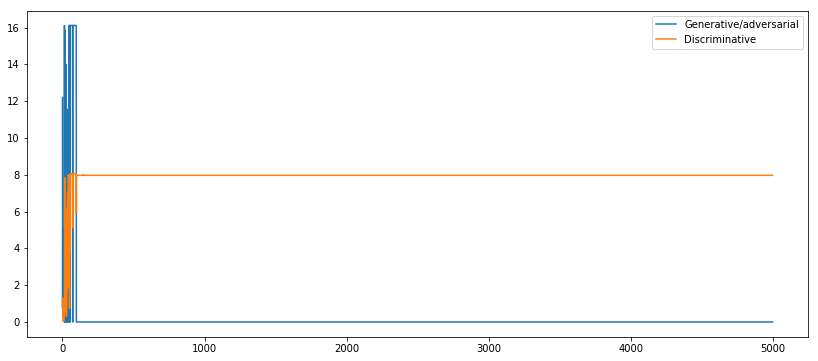

In [153]:
plot_gan(hist)

> e) Genere nuevos datos artificialmente a través del modelo generador *G* ya entrenado, para esto inicialice aleatoriamente el espacio oculto de dimensiones del generador a través de una distribución Uniforme entre -1 y 1, al igual como fue entrenado. Comente sobre las imágenes generadas y compare con lo realizado con el VAE, en temas de calidad visual y en tiempos de ejecución.

In [154]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)


In [206]:
def plot_image(images):
    plt.figure(figsize=(14,6))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

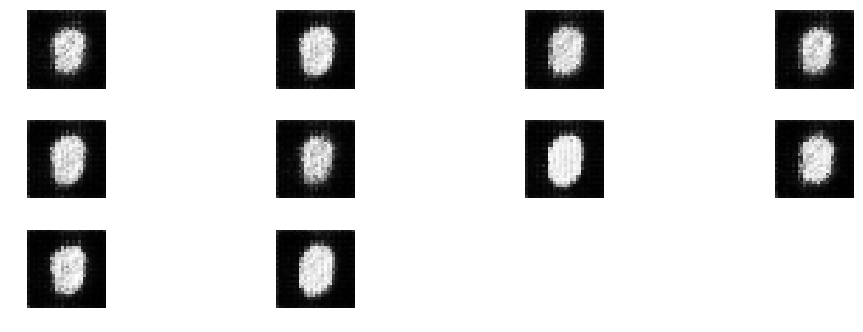

In [208]:
plot_image(images)

> f) ¿Qué le parece que resulta más crucial al momento de entrenar las GAN, saber que se tiene un buen generador e intentar mejorar el discriminador o saber que se tiene un buen discriminador e intentar mejorar el generador? en ambos casos para que el generador mejore. Experimente con una de las ideas, modifique el generador o el discriminador e intente generar mejores imágenes artificiales.

In [192]:
def train_k_discriminator(X_train,DM,AM,G,steps,batch_size,k):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        d_losses = []
        for i in range(k):
            # Make generative images
            image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
            noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
            generated_images = G.predict(noise_gen) #fake images
            # Train discriminator on generated images
            X = np.concatenate((image_batch, generated_images))
            #create labels
            y = np.ones([2*batch_size,1])
            y[batch_size:,:] = 0
            d_losses.append(DM.train_on_batch(X,y))
        d_loss = [np.mean(np.array(d_losses)[:,0]), np.mean(np.array(d_losses)[:,1])]
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history

In [193]:
train_steps = 500 #or few if  you want
hist_disc = train_k_discriminator(X_train,DM,AM,G,train_steps,64,3)

/home/fefi/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 3.703827, acc: 0.497396]  [G loss: 0.000000, acc: 1.000000]
1: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
5: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
6: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
7: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
8: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
9: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
10: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
11: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
12: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
13: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc

113: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
114: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
115: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
116: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
117: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
118: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
119: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
120: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
121: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
122: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
123: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
124: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
125: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
126: [D loss: 7.971192, acc: 0.500000]

224: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
225: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
226: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
227: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
228: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
229: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
230: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
231: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
232: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
233: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
234: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
235: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
236: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
237: [D loss: 7.971192, acc: 0.500000]

335: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
336: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
337: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
338: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
339: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
340: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
341: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
342: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
343: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
344: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
345: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
346: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
347: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
348: [D loss: 7.971192, acc: 0.500000]

446: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
447: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
448: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
449: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
450: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
451: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
452: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
453: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
454: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
455: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
456: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
457: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
458: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
459: [D loss: 7.971192, acc: 0.500000]

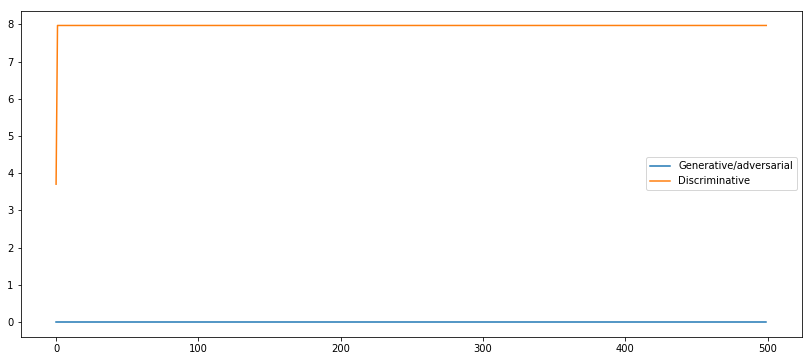

In [194]:
plot_gan(hist_disc)

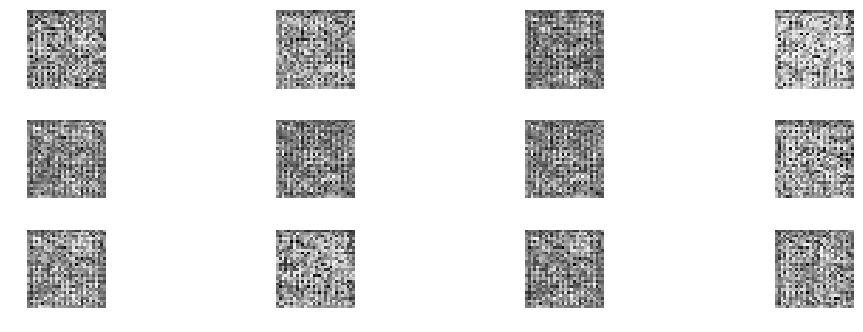

In [207]:
N = 12
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images_d = G.predict(noise)
plot_image(images_d)

> g) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida, diferente a la Uniforme, e **implementela** entrenando completamente el modelo.

In [222]:
def train_on_steps_norm(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.normal(0.,1.,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.normal(0.,1.,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history

In [223]:
train_steps = 500 #or few if  you want
hist_norm = train_on_steps_norm(X_train,DM,AM,G,train_steps,64)

/home/fefi/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.692873, acc: 0.468750]  [G loss: 15.953612, acc: 0.000000]
1: [D loss: 2.355550, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
2: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
3: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
5: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
6: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
7: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
8: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
9: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
10: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
11: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
12: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
13: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, ac

113: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
114: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
115: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
116: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
117: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
118: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
119: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
120: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
121: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
122: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
123: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
124: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
125: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
126: [D loss: 7.971192, acc: 0.500000]

224: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
225: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
226: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
227: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
228: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
229: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
230: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
231: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
232: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
233: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
234: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
235: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
236: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
237: [D loss: 7.971192, acc: 0.500000]

335: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
336: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
337: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
338: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
339: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
340: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
341: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
342: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
343: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
344: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
345: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
346: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
347: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
348: [D loss: 7.971192, acc: 0.500000]

446: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
447: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
448: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
449: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
450: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
451: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
452: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
453: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
454: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
455: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
456: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
457: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
458: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
459: [D loss: 7.971192, acc: 0.500000]

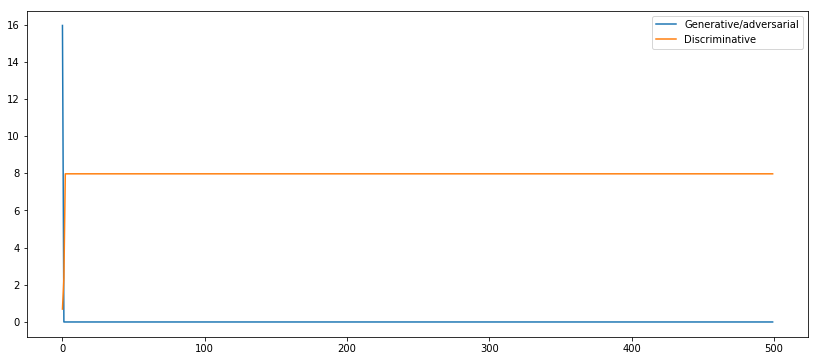

In [224]:
plot_gan(hist_norm)

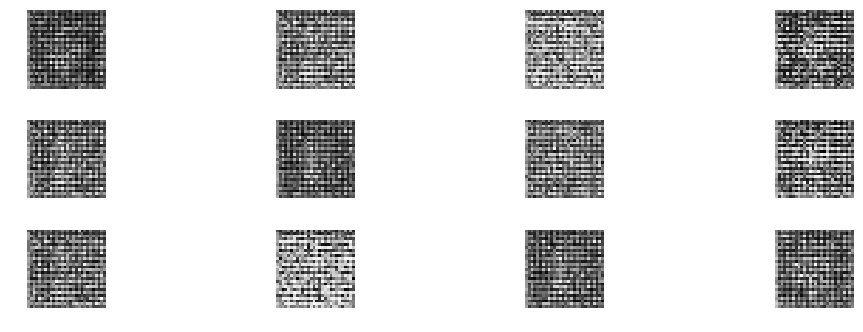

In [225]:
N = 12
noise = np.random.normal(0.0, 1.0, size=[N, input_dim]) 
images_norm = G.predict(noise)
plot_image(images_norm)

> h) Comente sobre el efecto de aumentar la dimensionalidad de las variables a generar datos $z$. Compare con lo acontecido con el método generativo VAE.